# Code for Simulating left-right theta sweeps in grid cells

This repository provides the code used to generate **left right theta sweeps** in grid cells.

For model details, please see:  
[Ji, Z., Chu, T., Wu, S., & Burgess, N. (2025). A systems model of alternating theta sweeps via firing rate adaptation. Current Biology, 35(4), 709-722.](https://www.sciencedirect.com/science/article/pii/S0960982224011746?via%3Dihub)

For empirical details, please see:
[Vollan, A. Z., Gardner, R. J., Moser, M. B., & Moser, E. I. (2025). Left–right-alternating theta sweeps in entorhinal–hippocampal maps of space. Nature, 639(8056), 995-1005.](https://www.nature.com/articles/s41586-024-08527-1)

---

*Created by **Zilong Ji**, UCL*

In [1]:
import numpy as np
import brainpy.math as bm

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns

import os
os.chdir("..")

from sweep.network_models import DCNet, GCNet, DCParams, GCParams
from sweep import plotting

from ratinabox.Environment import Environment
from ratinabox.Agent import Agent


%matplotlib inline
%load_ext autoreload
%autoreload 2

bm.set_dt(1.)  #simulation time stamp 1 ms

In [2]:
def simulate_dcgcnet(dcnet: DCNet, gcnet: GCNet, 
                   positions, directions, 
                   linear_speed_gains, ang_speed_gains,
                   theta_strength_hd=0, theta_strength_gc=0, 
                   theta_cycle_len=100):
    """Simulate direction-conjg grid cell-grid cell network over a trajectory of directions and velocity gains."""
    
    
    def step(i, position, direction, linear_gain, ang_gain):
        # theta oscillation phase
        t = i * bm.dt
        theta_phase = bm.mod(t, theta_cycle_len) / theta_cycle_len
        theta_phase = theta_phase * 2 * np.pi - np.pi
        
        #get theta modulation for both direction cell and grid cell
        #theta modulation scales with angular speed in direction cell network, and scales with linear speed in grid cell network
        
        theta_modulation_hd = 1+theta_strength_hd*(0.5+ang_gain)*bm.cos(theta_phase)
        theta_modulation_gc = 1+theta_strength_gc*(0.5+linear_gain)*bm.cos(theta_phase)
        
        # update direction cell network
        dcnet.step_run(i, direction, theta_modulation_hd)
        # get direction cell network activity
        dc_netactivity = dcnet.r 
        # get internal direction
        internal_direction = dcnet.center

        # update grid cell network
        gcnet.step_run(i, position, dc_netactivity, theta_modulation_gc)
    
        #get results
        internal_position = gcnet.center_position
        gc_netactivity = gcnet.r
        gC_bump = gcnet.gc_bump
               
        return (
            internal_position,
            internal_direction,
            gc_netactivity,
            gC_bump,
            dc_netactivity,
            theta_phase,
            theta_modulation_hd,
            theta_modulation_gc,
        )

    return bm.for_loop(
        step,
        (bm.arange(len(positions)), positions, directions, linear_speed_gains, ang_speed_gains),
        progress_bar=True
    )
    

### 1, Generate 'real' trajectory with RatInABox (George et al, 2024, eLife)

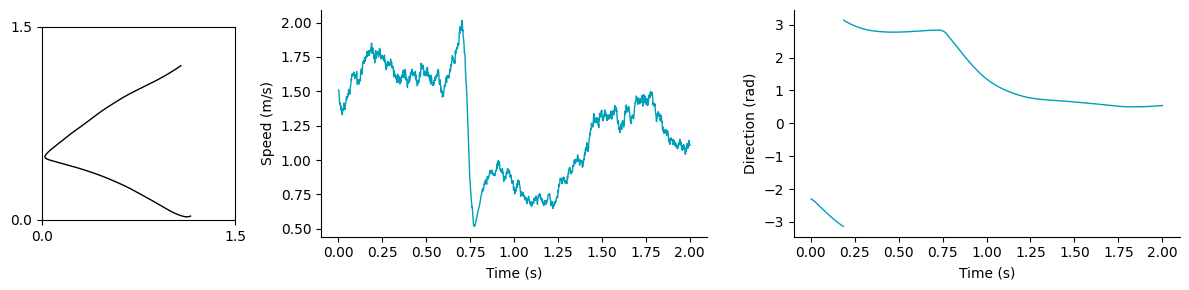

In [3]:
np.random.seed(10) #for reproducibility

simulate_time = 2 #in seconds
Env_size = 1.5 #in meters

Env = Environment(params={
    "scale":Env_size, #in meters
    "dimensionality": "2D",
})

Ag = Agent(Env, params = {
    "dt": 0.001, #time step 1 ms
    "speed_mean":2, #m/s
    "speed_std": 0.,
    "speed_coherence_time": 10,
    "rotational_velocity_std": 40*np.pi/180,  #set to 120 or 360 will increase the tutoriocity of the trajectory
    })

while Ag.t < simulate_time:
    Ag.update()
    
time_steps = np.array(Ag.history["t"])  
position = Ag.history['pos']
position = np.array(position)

# compute direction
direction_xy = Ag.history["head_direction"]
direction_xy = np.array(direction_xy)
direction = np.arctan2(direction_xy[:,1], direction_xy[:,0])

# compute angular velocity (unwrap to remove jumps at -pi/pi)
direction_unwrapped = np.unwrap(direction)
ang_velocity = np.diff(direction_unwrapped) / Ag.dt
ang_velocity = np.insert(ang_velocity, 0, 0)

# compute moving speed
moving_speed = np.linalg.norm(Ag.history['vel'], axis=1)

#plot 
fig, axs = plt.subplots(1,3,figsize=(12,3),dpi=100, width_ratios=[1,2,2])

ax = axs[0]
ax.plot(position[:,0], position[:,1], lw=1, color='black')
ax.set_xlim(0, Env_size)
ax.set_ylim(0, Env_size)
#equal axis
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([0, Env_size])
ax.set_yticks([0, Env_size])

ax = axs[1]
sns.despine(ax=axs[1])
ax.plot(time_steps, moving_speed, lw=1, color='#009FB9')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed (m/s)')

ax = axs[2]
sns.despine(ax=axs[2])
# find the jump points where the difference between two adjacent points is greater than pi
jumps = np.where(np.abs(np.diff(direction)) > np.pi)[0]
# set the jump points to NaN for plotting
direction_plot = direction.copy()
direction_plot[jumps + 1] = np.nan
ax.plot(time_steps, direction_plot, lw=1, color='#009FB9')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Direction (rad)')

plt.tight_layout()


### Simulate the network

In [6]:
bm.clear_buffer_memory(platform='gpu')
# simulation time step
bm.set_platform('gpu')

dc_net = DCNet(cell_num=100, 
               params=DCParams(adaptation_strength=15, noise_strength=0.),
               )   

gc_net = GCNet(num_dc = dc_net.cell_num,
               num_gc_x=100,
               params = GCParams(adaptation_strength=8,  mapping_ratio=5, noise_strength=0.),
               )

linear_speed_gains = moving_speed/np.max(moving_speed)
ang_speed_gains = ang_velocity/np.max(np.abs(ang_velocity))

# simulate the DC-Gc network
internal_position, internal_direction, gc_netactivity, gc_bump, dc_netactivity, theta_phase, theta_modulation_hd, theta_modulation_gc = simulate_dcgcnet(
    dc_net, gc_net, 
    positions=position, 
    directions=direction, 
    linear_speed_gains=linear_speed_gains, 
    ang_speed_gains=ang_speed_gains,
    theta_strength_hd=1.0, theta_strength_gc=0.5,
    theta_cycle_len=100,
)

  0%|          | 0/2001 [00:00<?, ?it/s]

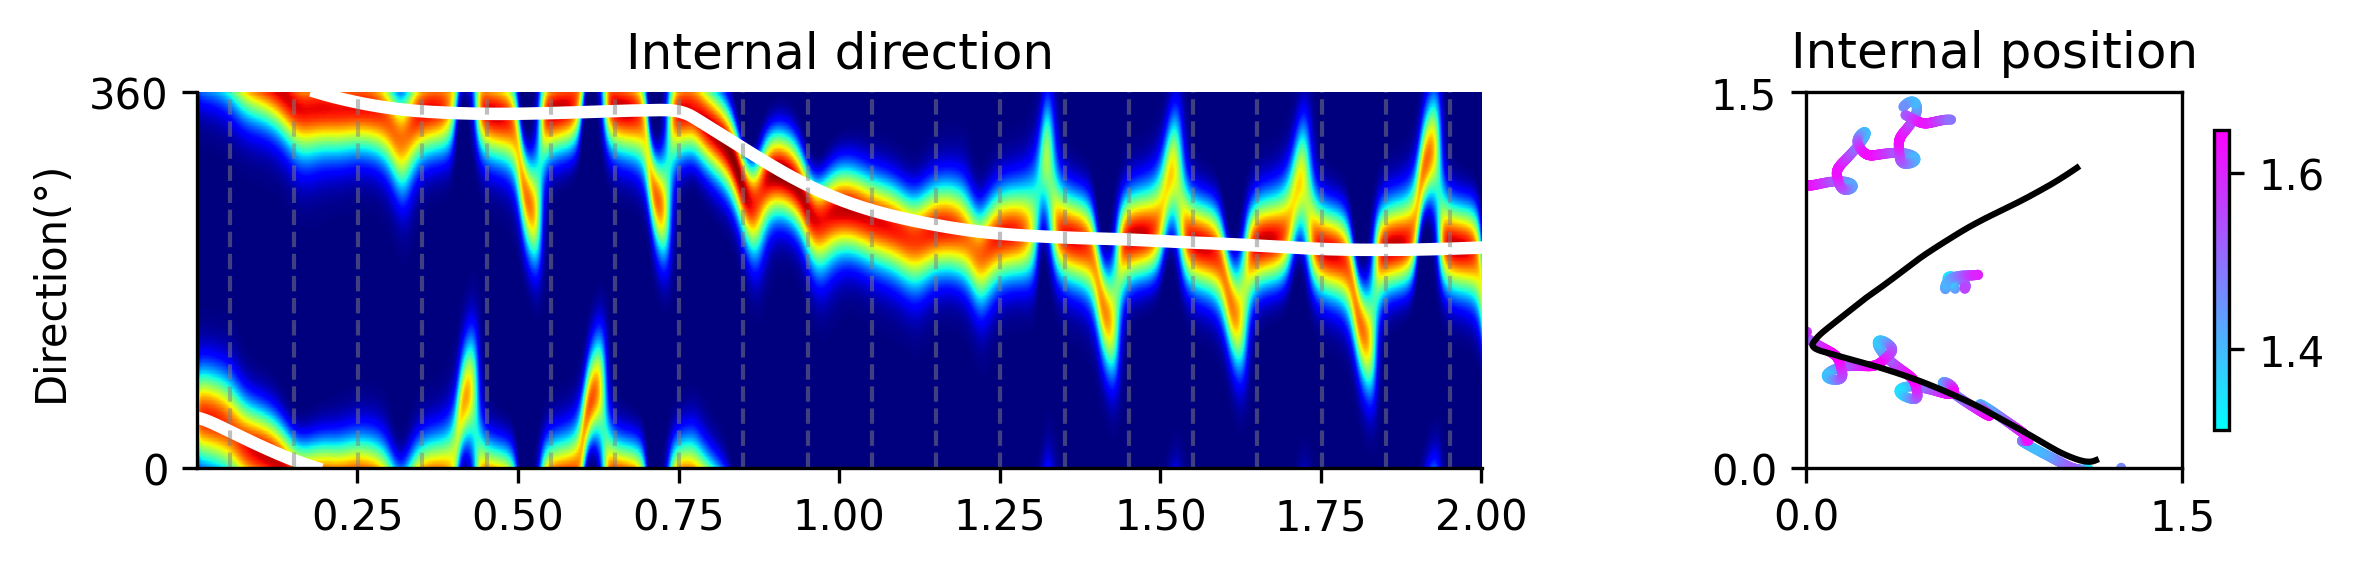

In [7]:
max_gc_activity = np.max(gc_netactivity, axis=1)
max_dc_activity = np.max(dc_netactivity, axis=1)
fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=300, width_ratios=[2,1])
s_size = 2

ax = axs[0]
ax = plotting.plot_population_activity(ax, time_steps, theta_phase, dc_netactivity, direction, 
                                       add_lines=True, atol=5e-2, cmap="jet")
ax.set_title('Internal direction')

ax = axs[1]
sc = ax.scatter(
                internal_position[:, 0],
                internal_position[:, 1],
                c=max_gc_activity[:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.plot(position[:, 0], position[:, 1], color="black")
ax.set_title('Internal position')
#equal axis 
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, Env_size)
ax.set_ylim(0, Env_size)
ax.set_xticks([0, Env_size])
ax.set_yticks([0, Env_size])

plt.tight_layout()
plt.show()

/tmp/ipykernel_353132/2791199451.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  red_dot.set_data(pos4ani[frame, 0], pos4ani[frame, 1])


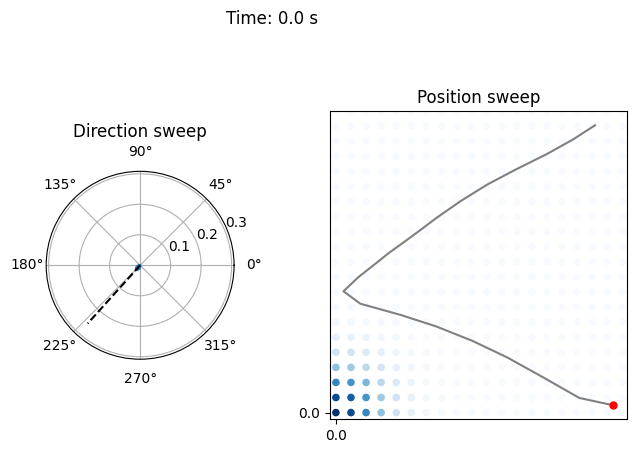

In [8]:
phi = gc_net.value_grid
n_step = 100

pos4ani = position[::n_step,:]
direction4ani = direction[::n_step]
gc_bump_4_animation = gc_bump[::n_step, :]
frames = gc_bump_4_animation.shape[0]
beta = np.linspace(-np.pi, np.pi, 100, endpoint=False)

fig, ax_ani = plt.subplots(1, 2, figsize=(8, 4), dpi=100, width_ratios=[1, 2])


sns.despine(ax=ax_ani[0], left=True, bottom=True, right=True, top=True)
# # Add text to the middle of ax_ani[0, 0]
time_text = ax_ani[0].text(1.2, 1.3, '', transform=ax_ani[0].transAxes, ha='center', va='center', fontsize=12)
ax_ani[0].set_xticks([])
ax_ani[0].set_yticks([])

ax_hd = plt.subplot(1, 2, 1, projection='polar')

netactivity4ani = dc_netactivity[::n_step, :]
ax_hd.set_ylim(0., np.max(netactivity4ani[:, :]) * 1.2)

line, = ax_hd.plot([], [])
hd_line, = ax_hd.plot([], [], 'k--')
ax_hd.set_title("Direction sweep")

ax_gc = ax_ani[1]
ax_gc.set_xticks([0, Env_size])
ax_gc.set_yticks([0, Env_size])
ax_gc.set_aspect("equal")

ax_gc.plot(pos4ani[:, 0], pos4ani[:, 1], color="gray")

vmin1 = 0
vmax1 = np.max(gc_bump_4_animation)
scatter1 = ax_gc.scatter([], [], c=[], s=20, cmap="Blues", vmin=vmin1, vmax=vmax1)
ax_gc.set_title("Position sweep")
red_dot, = ax_gc.plot([], [], 'ro', markersize=5)
bump_centers = []

def update(frame):
    y_hd = netactivity4ani[frame].flatten()
    line.set_data(beta, y_hd)
    hd_line.set_data([direction4ani[frame], direction4ani[frame]], [0, np.max(netactivity4ani[:, :])])
    
    
    y1 = gc_bump_4_animation[frame].flatten()
    scatter1.set_offsets(np.column_stack((phi[:, 0], phi[:, 1])))
    scatter1.set_array(y1)
    red_dot.set_data(pos4ani[frame, 0], pos4ani[frame, 1])
    
    time_text.set_text(f"Time: {frame / 100:.1f} s")
    return scatter1

ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=False)

HTML(ani.to_jshtml())

# ani.save("/home/zilong/Desktop/ThetaSweepModelling/figures/gridcell_sweeps.gif",
#          writer="pillow", fps=10)

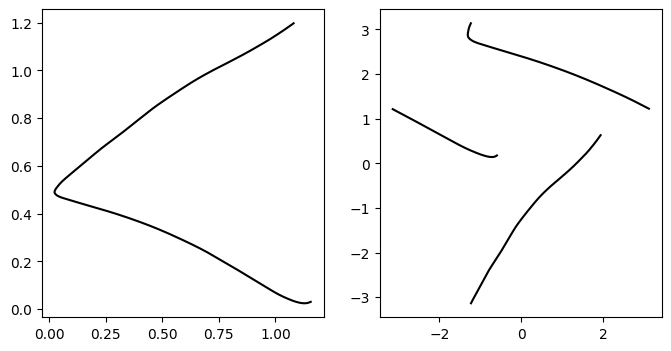

In [8]:
pos2phase = gc_net.position2phase(position.T)
#to numy
pos2phase = np.array(pos2phase) #(N,2)

fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=100, width_ratios=[1,1])

ax = axs[0]
ax.plot(position[:,0], position[:,1], color='black')

ax = axs[1]

x = pos2phase[0, :]
y = pos2phase[1, :]
# Find jumps where either x or y jumps more than π
jumps_x = np.where(np.abs(np.diff(x)) > np.pi)[0]
jumps_y = np.where(np.abs(np.diff(y)) > np.pi)[0]
jumps = np.unique(np.concatenate([jumps_x, jumps_y]))
# Insert NaN at all jump points
x_plot = x.copy()
y_plot = y.copy()
x_plot[jumps + 1] = np.nan
y_plot[jumps + 1] = np.nan
ax.plot(x_plot, y_plot, color="black")



/tmp/ipykernel_362904/3973435498.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  red_dot.set_data(pos2phase4ani[0, frame], pos2phase4ani[1,frame])


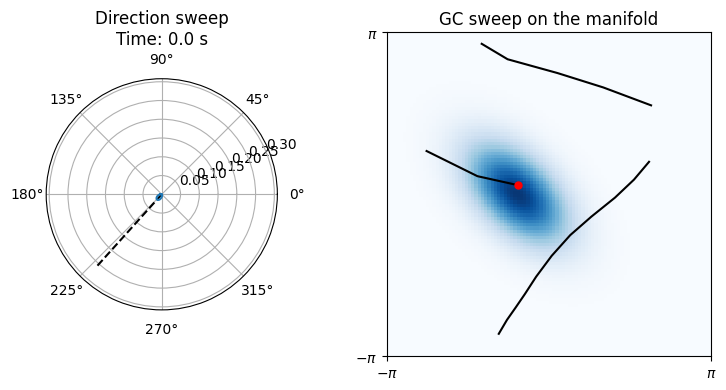

In [10]:
grid_cell_activity = gc_netactivity.reshape(-1, gc_net.num_gc_1side, gc_net.num_gc_1side)

n_step = 100

pos2phase4ani = pos2phase[:,::n_step]
direction4ani = direction[::n_step]
gc_bump4ani = grid_cell_activity[::n_step, :, :]
frames = gc_bump4ani.shape[0]
direction_bins = np.linspace(-np.pi, np.pi, 100, endpoint=False)

fig, ax_ani = plt.subplots(1, 2, figsize=(8, 4), dpi=100, width_ratios=[1, 2])

sns.despine(ax=ax_ani[0], left=True, bottom=True, right=True, top=True)
# # Add text to the middle of ax_ani[0, 0]
time_text = ax_ani[0].text(1.2, 1.3, '', transform=ax_ani[0].transAxes, ha='center', va='center', fontsize=12)
ax_ani[0].set_xticks([])
ax_ani[0].set_yticks([])

ax_dc = plt.subplot(1, 2, 1, projection='polar')

dc_activity_4_ani = dc_netactivity[::n_step, :]
ax_dc.set_ylim(0., np.max(dc_activity_4_ani[:, :]) * 1.2)

hd_line, = ax_dc.plot([], [], 'k--') #actual direction
id_line, = ax_dc.plot([], []) #iternal direction

ax_gc = ax_ani[1]
ax_gc.set_xticks([-np.pi, np.pi])
ax_gc.set_yticks([-np.pi, np.pi])
#set ticklabels to pi and -pi
ax_gc.set_xticklabels(['$-\pi$', '$\pi$'])
ax_gc.set_yticklabels(['$-\pi$', '$\pi$'])
ax_gc.set_aspect("equal")


x = pos2phase4ani[0, :]
y = pos2phase4ani[1, :]
# Find jumps where either x or y jumps more than π
jumps_x = np.where(np.abs(np.diff(x)) > np.pi)[0]
jumps_y = np.where(np.abs(np.diff(y)) > np.pi)[0]
jumps = np.unique(np.concatenate([jumps_x, jumps_y]))
# Insert NaN at all jump points
x_plot = x.copy()
y_plot = y.copy()
x_plot[jumps + 1] = np.nan
y_plot[jumps + 1] = np.nan
ax_gc.plot(x_plot, y_plot, color="black")
# ax_gc.plot(pos2phase4ani[0,:], pos2phase4ani[1,:], color="gray")

vmin1 = 0
vmax1 = np.max(gc_bump4ani)
gc_activity_im = ax_gc.imshow(gc_bump4ani[0], cmap="Blues", vmin=vmin1, vmax=vmax1,
                  extent=[-np.pi, np.pi, -np.pi, np.pi], origin="lower", aspect="equal")
ax_gc.set_title("GC sweep on the manifold")
red_dot, = ax_gc.plot([], [], 'ro', markersize=5)
bump_centers = []

def update(frame):
    hd_line.set_data([direction4ani[frame], direction4ani[frame]], [0, np.max(dc_activity_4_ani[:, :])])
    id_line.set_data(direction_bins, dc_activity_4_ani[frame])
    
    gc_activity_im.set_data(gc_bump4ani[frame])
    
    red_dot.set_data(pos2phase4ani[0, frame], pos2phase4ani[1,frame])
    
    ax_dc.set_title(f"Direction sweep\nTime: {frame/100:.1f} s")
    return hd_line, id_line, gc_activity_im, red_dot

plt.tight_layout()

ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=False)

HTML(ani.to_jshtml())

# ani.save("/home/zilong/Desktop/ThetaSweepModelling/figures/gridcell_sweeps.gif",
#          writer="pillow", fps=10)